# RNN Evaluation

From our paper on "Explainable Prediction of Acute Myocardial Infarction using Machine Learning and Shapley Values"

In [4]:
# Import libraries
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Layer, GRU, LSTM, Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import LeakyReLU
from keras import regularizers, backend, initializers
from keras.models import Sequential
from keras.utils import to_categorical
from keras.initializers import Ones, Zeros
import keras.backend as K
from keras.models import load_model

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn import preprocessing

import time
import gc
import pandas as pd
import numpy as np
import pylab as plt
import tensorflow as tf
from numpy import loadtxt
from numpy import savetxt
from tensorflow.python.framework import ops
print(tf.__version__)

# Visualization libraries
import seaborn as sns

# Loading Data

In [ ]:
# Load data
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')

# Split array
train_x = train[:,:11]
test_x = test[:,:11]
train_y = train[:,11]
test_y = test[:,11]

train_x_noageandsex = train_x[:,:9]
test_x_noageandsex = test_x[:,:9]
train_y_noageandsex = train_y
test_y_noageandsex = test_y

In [6]:
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

X_train_noageandsex = np.reshape(train_x_noageandsex, (train_x_noageandsex.shape[0], 1, train_x_noageandsex.shape[1]))
X_test_noageandsex = np.reshape(test_x_noageandsex, (test_x_noageandsex.shape[0], 1, test_x_noageandsex.shape[1]))
train_y_noageandsex = to_categorical(train_y_noageandsex)

# Model Evaluation + Confusion Matrix

In [8]:
model = load_model('model_noageandsex1_final.h5', custom_objects={'LayerNormalization': LayerNormalization})
model.summary()

# Test the model
start = time.clock() 
pred_test = model.predict(X_test_noageandsex)
end = time.clock()
pred_test = np.argmax(pred_test, axis=-1)
print("Time for prediction: {} ".format((end-start))) 

# Get f1 score
f1 = f1_score(test_y, pred_test, average="macro")
print("Test f1 score : %s "% f1)

# Get ROC AUC score
roc = roc_auc_score(test_y_noageandsex, pred_test)
print("Test ROC AUC Score : %s "% roc)

# Get the accuracy 
acc = accuracy_score(test_y_noageandsex, pred_test)
print("Test accuracy score : %s "% acc)

# Get the specificity
tn, fp, fn, tp = confusion_matrix(test_y_noageandsex, pred_test).ravel()
specificity = tn / (tn+fp)
print("Specificity : %s "% specificity)

# Get the sensitivity
sensitivity= tp / (tp+fn)
print("Sensitivity: %s "% sensitivity)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 10)             600       
_________________________________________________________________
layer_normalization_1 (Layer (None, 1, 10)             20        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 10)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 9)              540       
_________________________________________________________________
layer_normalization_2 (Layer (None, 1, 9)              18        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 9)              0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1, 7)             

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Time for prediction: 8.034883099999888 
Test f1 score : 0.770089366791743 
Test ROC AUC Score : 0.7633939364867299 
Test accuracy score : 0.8013578169027402 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


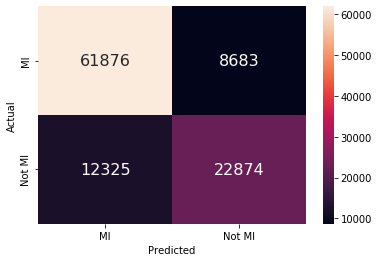

In [9]:
# Confusion matrix
confusion = confusion_matrix(test_y_noageandsex, pred_test)
sns.heatmap(data=confusion, annot=True, xticklabels=["MI", "Not MI"], yticklabels=["MI", "Not MI"], fmt = "d", annot_kws={"fontsize":16})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.yticks(va="center")
plt.show()